In [1]:
!pip3 install keras pandas plotly seaborn numpy sklearn quandl

In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [4]:
data1 = pd.read_csv(filepath_or_buffer="bitcoinprices.txt", names=['stamp','price'])
data2 = pd.read_csv(filepath_or_buffer="sentiment6.txt", names=['stamp','sentiment'])

In [5]:
data1.head()

stamp   price
0  20160227   427.1
1  20161118   750.9
2  20160613   690.9
3  20160808   588.7
4  20170206  1047.3

In [6]:
data2.info()
data2.dropna(axis=1,how='all')
data2['sentiment'] = data2.sentiment.replace('None', 0).astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 2 columns):
stamp        643 non-null int64
sentiment    643 non-null object
dtypes: int64(1), object(1)
memory usage: 10.2+ KB


In [7]:
data = pd.merge(data1,data2,on='stamp', how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 0 to 642
Data columns (total 3 columns):
stamp        643 non-null int64
price        643 non-null float64
sentiment    643 non-null float64
dtypes: float64(2), int64(1)
memory usage: 20.1 KB


In [8]:
data.describe()

stamp       price   sentiment
count  6.430000e+02   643.00000  643.000000
mean   2.016561e+07  1622.81804    0.302272
std    4.942045e+03  1600.83981    0.096245
min    2.016021e+07   379.20000   -0.040372
25%    2.016072e+07   603.50000    0.249266
50%    2.016123e+07   861.70000    0.304954
75%    2.017061e+07  2355.60000    0.379694
max    2.017111e+07  7489.90000    0.518510

In [9]:
data['stamp'] = pd.to_datetime(data['stamp'].apply(str),format='%Y%m%d')
data = data.sort_values(by='stamp')
data.head()

stamp  price  sentiment
573 2016-02-11  379.2   0.306488
427 2016-02-12  389.0   0.260142
212 2016-02-13  397.7   0.304902
113 2016-02-14  406.8   0.308635
590 2016-02-15  400.9   0.321268

In [10]:
csvFile = open('merged_data.csv', 'w')
data.to_csv(r'merged_data.csv', index=None, header=True)

In [11]:
data1 = pd.read_csv('merged_data.csv')


In [13]:
btc_trace = go.Scatter(x=data['stamp'], y=data['sentiment'], name= 'Sentiment')
py.iplot([btc_trace])

In [14]:
btc_trace = go.Scatter(x=data['stamp'], y=data['price'], name= 'Price')
py.iplot([btc_trace])

In [15]:
data['price'].replace(0, np.nan, inplace=True)
data['price'].fillna(method='ffill', inplace=True)

In [16]:
btc_trace = go.Scatter(x=data['stamp'], y=data['price'], name= 'Price')
py.iplot([btc_trace])

In [17]:
from sklearn.preprocessing import MinMaxScaler
values = data['price'].values.reshape(-1,1)
sentiment = data['sentiment'].values.reshape(-1,1)
values = values.astype('float32')
sentiment = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [18]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
split = train_size

450 193


In [19]:
def create_dataset(dataset, look_back, sentiment):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        np.append(a,sentiment[i])
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [20]:
look_back = 1
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size])
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)])

449
192


In [21]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

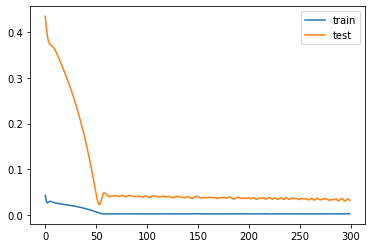

In [23]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

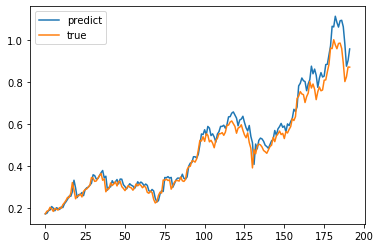

In [24]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [25]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [26]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 319.261


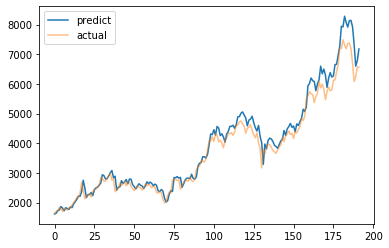

In [27]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [28]:
predictDates = data.tail(len(testX)).stamp

In [29]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [30]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

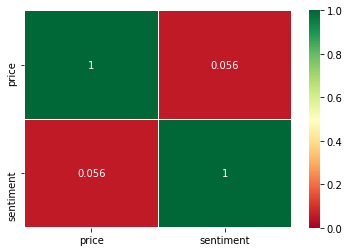

In [31]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [32]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [33]:
values = data[['price']].values
values = values.astype('float32')

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [35]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

var1(t-1)   var1(t)
1   0.000000  0.001378
2   0.001378  0.002602
3   0.002602  0.003881
4   0.003881  0.003052
5   0.003052  0.004599

In [36]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(449, 1, 1) (449,) (193, 1, 1) (193,)


In [37]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

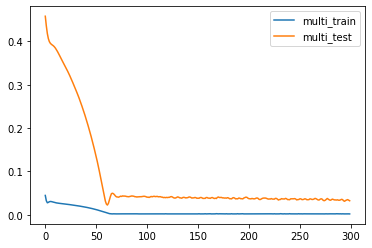

In [38]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

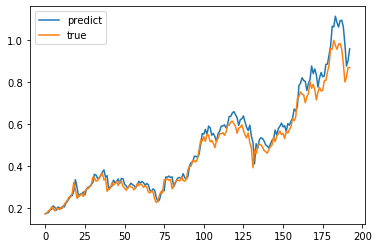

In [39]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [40]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [41]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 328.609


In [42]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])